In [59]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb

# from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [60]:
## Read the subcritical coal power plant data

sub_critical = pd.read_csv('CEEW_subcritical_with_ws_price.csv')

all_heat_rate = sub_critical['Actual SHR']* 3.96567/1000
all_capacity  = sub_critical['Capacity']
all_age       = sub_critical['Age']
all_region     = sub_critical['Region']
all_PLF        = sub_critical['Actual avg PLF']
all_water_stress = sub_critical['bws_score']
all_price = sub_critical['coal_price']


1. Find the correlation between the features

In [61]:
data = pd.DataFrame({'heat_rate': all_heat_rate,
                     'capacity': all_capacity,
                     'age': all_age, 
                     'PLF': all_PLF,
                     'water stress': all_water_stress,
                     'region': all_region,
                     'price': all_price
                     })

# change the state to one hot encoding
data = pd.get_dummies(data, columns=['region']) # aggregate the states here. 

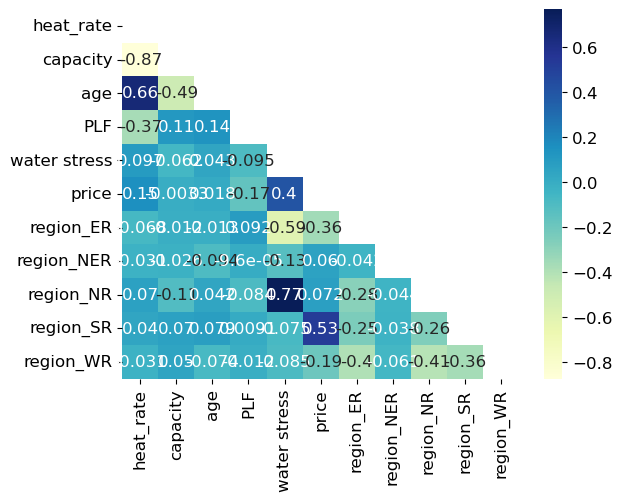

In [62]:
mask = np.triu(np.ones_like(data.corr()))
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.savefig('ML_training_plots/Feature_correlation_sub.png', bbox_inches='tight')

2. Fit the prediction model using data

In [63]:
X = data.drop('heat_rate', axis=1)
y = data['heat_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# add constant
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [49]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge

In [50]:
good_models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=15, n_estimators=200),
    'RandomForestRegressor': RandomForestRegressor(max_depth=None),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=None),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=400),
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(alpha=1),
    'SVR': SVR(C=0.1, gamma=0.01, kernel='linear'),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=2, weights='distance'),
}

In [51]:
# Cross validation
kf = KFold(n_splits=5)
res = {}

# use mean squared error, mean absolute error, mean absolute percentage error
for name, model in good_models.items():
    print(name)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error',
                                                                     'neg_mean_absolute_percentage_error', 'r2'))
    res[name] = scores

GradientBoostingRegressor
RandomForestRegressor
DecisionTreeRegressor
XGBRegressor
LinearRegression
RidgeRegression
SVR
KNeighborsRegressor


[0.9647687051114131, 0.9508261553780762, 0.9227463461792456, 0.9625014156479569, 0.9581399098482928, 0.9563897910200112, 0.9479452833316827, 0.9259223385263751]


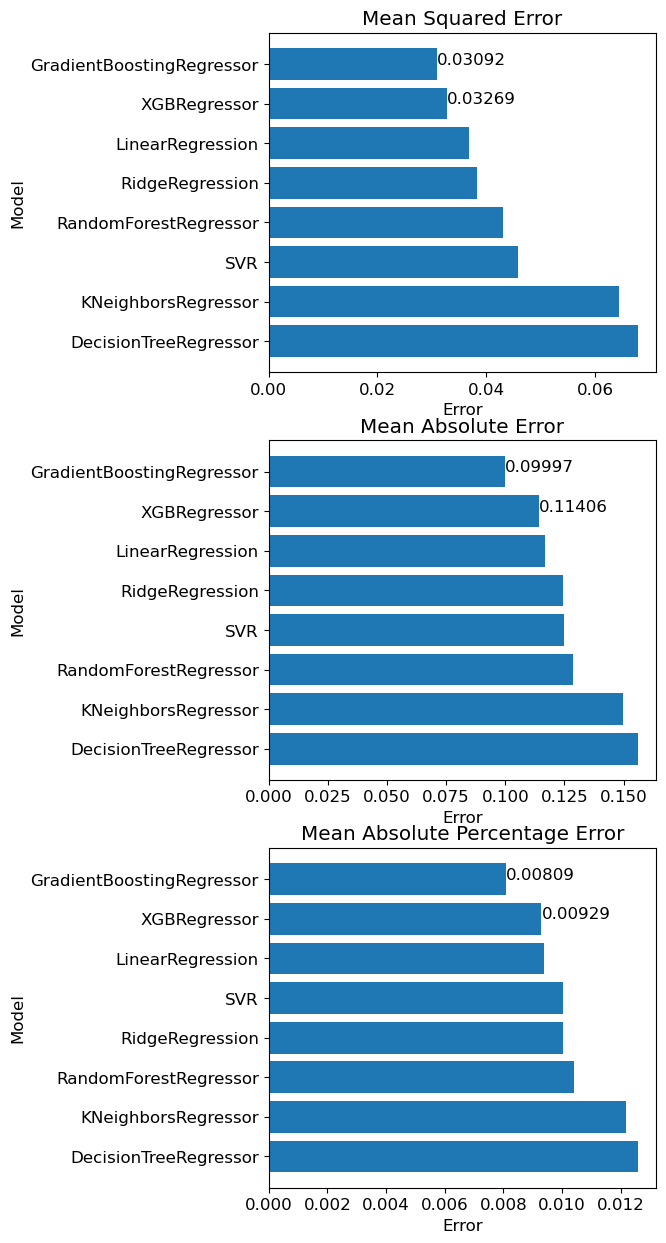

In [70]:
# taking the negative mean. test_neg_mean_squared_error, test_neg_mean_absolute_error, test_neg_mean_absolute_percentage_error
res_mean = {name: {'test_mean_squared_error': -np.mean(scores['test_neg_mean_squared_error']),
                  'test_mean_absolute_error': -np.mean(scores['test_neg_mean_absolute_error']),
                  'test_mean_absolute_percentage_error': -np.mean(scores['test_neg_mean_absolute_percentage_error']),
                  'test_mean_r2': np.mean(scores['test_r2'])} for name, scores in res.items()}

titles = {
    'test_mean_squared_error': 'Mean Squared Error',
    'test_mean_absolute_error': 'Mean Absolute Error',
    'test_mean_absolute_percentage_error': 'Mean Absolute Percentage Error',
    'test_mean_r2': 'Mean R Square',
}

print([res_mean[name]['test_mean_r2'] for name in res_mean])

# 3 horizontal bar plots for each of the errors.
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.rcParams.update({'font.size': 12})
for i, error in enumerate(['test_mean_squared_error', 'test_mean_absolute_error', 'test_mean_absolute_percentage_error']):
    # sort by the error
    res_mean = dict(sorted(res_mean.items(), key=lambda item: -item[1][error]))

    ax[i].barh(list(res_mean.keys()), [res_mean[name][error] for name in res_mean])
    ax[i].set_title(titles[error])
    ax[i].set_xlabel('Error')
    ax[i].set_ylabel('Model')

    # label bars with values
    for index, value in enumerate([res_mean[name][error] for name in res_mean]):
        if index > 5:
            ax[i].text(value, index, str(round(value, 5)))
# save
plt.savefig('ML_training_plots/Model_comparison_sub.png', bbox_inches='tight')


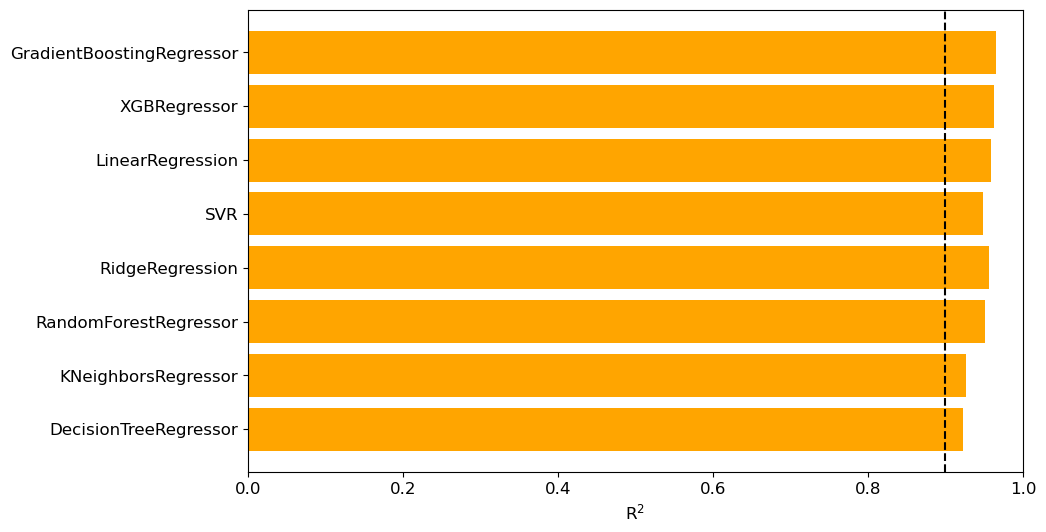

In [80]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.barh(list(res_mean.keys()), [res_mean[name]['test_mean_r2'] for name in res_mean], color='orange')
plt.axvline(x=0.9, linestyle='--', color='k')
plt.xlim(0, 1)
plt.xlabel('R$^2$')
plt.savefig('ML_training_plots/Model_comparison_R2_sub.png', bbox_inches='tight')

2.9086355185488753


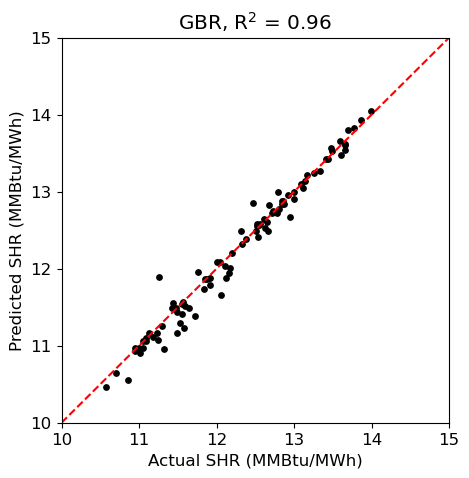

In [79]:
good_models['GradientBoostingRegressor'].fit(X_train, y_train)
prediction = good_models['GradientBoostingRegressor'].predict(X_test)

print(sum(prediction[:]- y_test[:]))
plt.figure(figsize=(5, 5))
plt.scatter(prediction, y_test, s=15, color='black')
plt.plot([10, 15], [10, 15], linestyle='--', color='red')
plt.xlim([10, 15])
plt.xlabel('Actual SHR (MMBtu/MWh)')
plt.ylabel('Predicted SHR (MMBtu/MWh)')
plt.title('GBR, '+'R$^2$ = '+str(np.round(max([res_mean[name]['test_mean_r2'] for name in res_mean]), 2)))
plt.ylim([10, 15])
plt.savefig('Parity_plots_subcritical.png', bbox_inches='tight')

PermutationExplainer explainer: 370it [00:34,  7.65it/s]                         
PermutationExplainer explainer: 370it [00:41,  6.80it/s]                         


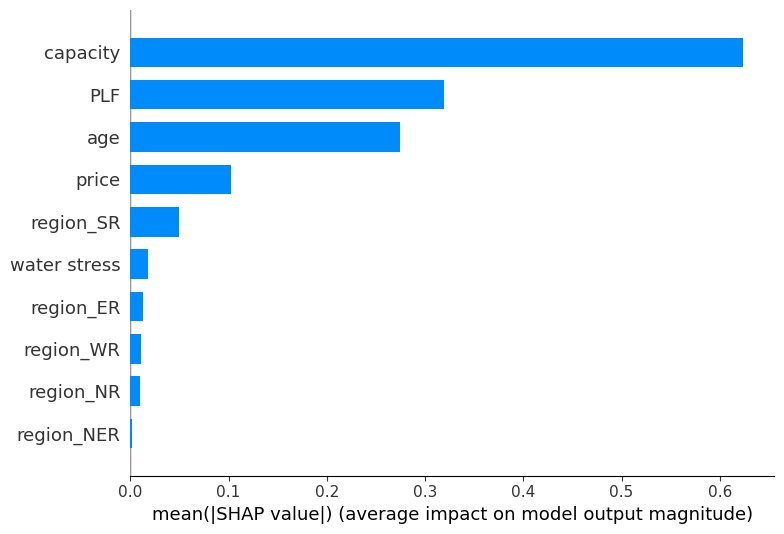

In [54]:
import shap
idx = 1
sorted_model_names = sorted(good_models.keys(), key=lambda name: res_mean[name]['test_mean_squared_error'])
for name in sorted_model_names:
    model = good_models[name]
    if (name in ['KNeighborsRegressor', 'SVR', 'LinearRegression', 'RidgeRegression']):
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer(X_train)
    else:
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
    features_names = [0] + list(X.columns)
    shap_figure = shap.summary_plot(shap_values, X_train,
                      feature_names=[0] + list(X.columns), plot_type='bar',
                      max_display=10, show=False)
    plt.savefig('./SHAP_plot/'+str(name)+'_summary_subcritical.png')
    idx += 1

3. Predict the heat rate of GEM database

In [55]:
## Read the subcritical coal power plant data

gem_coal = pd.read_csv('gem_with_ws_price.csv')
gem_sub_critical = gem_coal[gem_coal['Combustion technology']=='subcritical']
gem_sub_critical = gem_sub_critical[gem_sub_critical['Status']=='operating']

gem_heat_rate = gem_sub_critical['Heat rate (Btu per kWh)'] /1000
gem_capacity  = gem_sub_critical['Capacity (MW)']
gem_age       = 50-gem_sub_critical['Remaining plant lifetime (years)']
gem_state     = gem_sub_critical['Subnational unit (province, state)']
gem_price = gem_sub_critical['coal_price']
gem_water_stress = gem_sub_critical['bws_score']

gem_state = gem_state.reindex()

# replace Punjab state with punjab
gem_state = gem_state.replace('Punjab state', 'Punjab')

state_to_zone = pd.read_csv('30_to_5zones.csv')
gem_state_with_zone = pd.merge(gem_sub_critical, state_to_zone, left_on='Subnational unit (province, state)', right_on='States', how='left')
gem_zone = gem_state_with_zone["Region_y"]
gem_zone

0      WR
1      ER
2      ER
3      ER
4      ER
       ..
699    WR
700    WR
701    WR
702    WR
703    NR
Name: Region_y, Length: 704, dtype: object

In [56]:
X_prediction = pd.DataFrame(
    {
        "heat_rate": gem_heat_rate.values,
        "capacity": gem_capacity.values,
        "age": gem_age.values,
        "PLF": np.array([0.5] * len(gem_heat_rate)),
        "water stress": gem_water_stress,
        "region": gem_zone.values,
        "price": gem_price
    }
)
X_prediction = pd.get_dummies(
    X_prediction, columns=["region"]
)  # aggregate the states here.
X_prediction = X_prediction.drop("heat_rate", axis=1)

X_prediction = scaler.transform(X_prediction)
X_prediction = np.c_[np.ones(X_prediction.shape[0]), X_prediction]

# replace nan with 0
X_prediction = np.nan_to_num(X_prediction)

In [57]:
good_models['GradientBoostingRegressor'].fit(X_train, y_train)
predicted_gem_heat_value = good_models['GradientBoostingRegressor'].predict(X_prediction)

gem_sub_critical['Predicted_HR'] = predicted_gem_heat_value
# save gem_sub_critical
gem_sub_critical.to_csv('gem_predicted_subcritical.csv')

print(predicted_gem_heat_value)

[11.17528364 13.03251377 13.03251377 13.03251377 13.03251377 13.03251377
 13.03251377 13.17953887 13.12317764 13.28069396 13.2735108  13.46174323
 13.46174323 13.40906278 12.49767446 12.50206355 12.50345165 12.50345165
 12.50345165 11.1744184  11.08313677 13.90651085 13.18506465 13.90651085
 13.90651085 13.90651085 13.7295754  13.67631006 13.41112426 13.19236569
 13.18506465 13.11395058 13.06575319 13.05208964 13.05208964 13.05208964
 13.00308652 13.65588697 13.54677564 13.54677564 12.44677331 12.44333122
 11.2367148  11.2367148  11.26155356 11.26265829 11.08616339 11.05960478
 13.30101865 13.3251511  13.38085907 13.19302422 13.16311519 13.15686117
 12.94388664 12.90056234 13.40161686 13.95238723 13.95238723 13.95238723
 13.95238723 13.14279174 13.14279174 13.12630792 13.12630792 12.36711458
 12.27871493 12.35925029 12.35925029 13.35135833 13.95368773 13.4881147
 11.17528364 11.08532358 14.02692074 13.95545767 12.28315932 12.24618773
 13.17840049 13.27943916 13.23010565 13.25464025 13.

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.


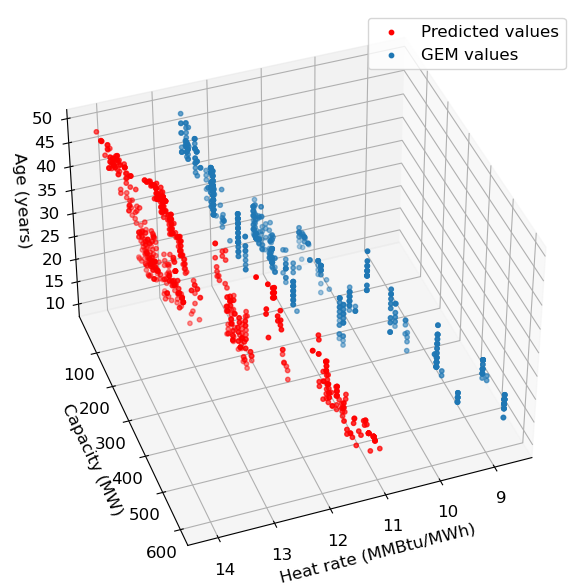

In [58]:

ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = predicted_gem_heat_value
y = gem_capacity
ax.scatter(x, y, zs=gem_age, zdir='z', color='red', s=10, label='Predicted values')

x1 = gem_heat_rate
y1 = gem_capacity
ax.scatter(x1, y1, zs=gem_age, zdir='z', color='tab:blue', s=10, label='GEM values')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlabel('Heat rate (MMBtu/MWh)')
ax.set_ylabel('Capacity (MW)')
ax.set_zlabel('Age (years)')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=40., azim=70)
ax.dist = 10


plt.tight_layout()
plt.savefig('ML_training_plots/Gem_coal_3D_prediction_charateristics_sub.png')